# Clean Architecture

clean architecture を守って mictlan に nbviewer モジュールを作ったので構成の説明をする

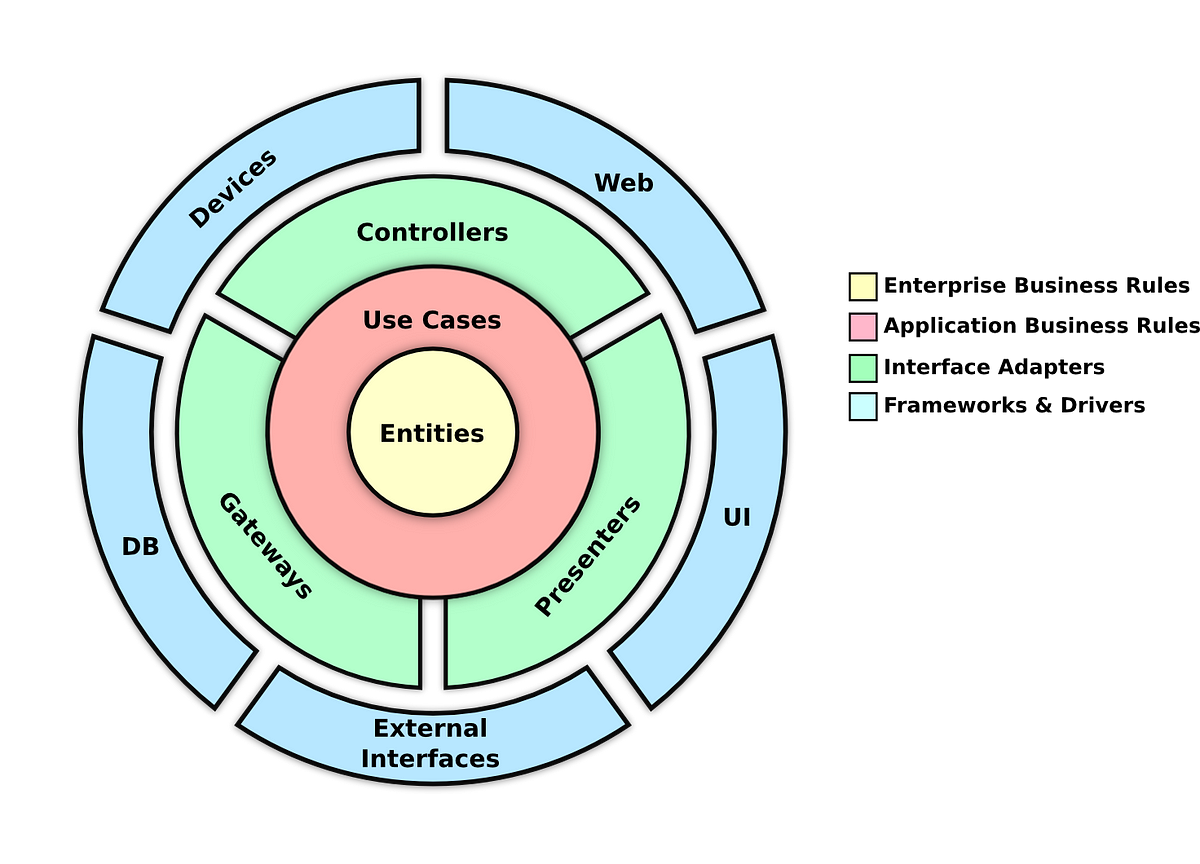


In [1]:
from lib.pkg import mermaid

mermaid.display_file(
    "clean-architecture.mmd")

(モジュール名\_Class 名という名前になってる)

## Entities

Name, Notebook

ソースコード:

```typescript
import type { Brand } from "../../pkg/types";

export type Name = Brand<string, "Name">;
export type Notebook = Brand<string, "Notebook">;
```

中心が一番依存が少ないので、一番中心にある Entity からソースコードを書いた

型安全のために[Type Branding](https://www.bing.com/search?q=Type+Branding)している

## Use Cases

Application レイヤーとも呼ばれ、Interface Adapter と Domain Service を含む

- Interface Adapter: Presenter, Library
- Domain Service: App

ソースコード:

```typescript
export interface Library {
  notebook(name: Name): Promise<Notebook>;
}

export interface Presenter<T> {
  render(notebook: Notebook): T;
}

export class App<T> {
  constructor(private library: Library, private presenter: Presenter<T>) {
    this.library = library;
    this.presenter = presenter;
  }

  async show(name: Name): Promise<T> {
    const notebook = await this.library.notebook(name);
    return this.presenter.render(notebook);
  }
}
```

名前を受け取ると、図書館から本を探して、発表者に頼んで見やすく整える、といった内容が書かれている

これは Entity の次に書いたコードで、他のモジュールへの import 文がないことから、外部に依存していない

## Presenters (Interface Adapters)

jupyter notebook を HTML に見やすく整える Presenter を作った

上で作った nbviewer に依存し、import している

ソースコード:

```typescript
import * as nbviewer from "../internal/nbviewer";
import { type Brand, make } from "../pkg/types";

// HTMLはviewmodel
export type HTML = Brand<string, "HTML">;

export class Presenter implements nbviewer.Presenter<Promise<HTML>> {
  async render(notebook: nbviewer.Notebook): Promise<HTML> {
    try {
      const respose = new Response(notebook);
      const output =
        await Bun.$`jupyter nbconvert --to html --execute --stdin --stdout < ${respose}`.text();
      const html = make<HTML>();
      return html(output);
    } catch (error) {
      console.error("Failed to convert notebook:", error);
      throw error;
    }
  }
}
```

超雑いけどやりたいことできてるのでおｋ

## Controllers, Gateways (Interface Adapters)

Controller や Gateway は、External Interfaces や Frameworks や Web と、Application(Use Cases)との懸け橋になっている

#### localfile を使った Library

nbviewer に依存し、import している

```typescript
import * as nbviewer from "../internal/nbviewer";
import { make } from "../pkg/types";
import { join } from "path";

export class Library implements nbviewer.Library {
  async notebook(name: nbviewer.Name): Promise<nbviewer.Notebook> {
    if (!/^[a-zA-Z0-9_-]+$/.test(name)) {
      throw Error("invalid notebook name");
    }
    const fullpath = join("web/notebook/", `${name}.ipynb`);
    const file = Bun.file(fullpath);
    if (await file.exists()) {
      const notebook = make<nbviewer.Notebook>();
      const noteText = await file.text();
      return notebook(noteText);
    } else {
      throw Error("notebook not found");
    }
  }
}
```

#### [elysia](https://elysiajs.com)を使ったサーバー

ここまで書いて来たコンポーネントを Dependency Injection してサーブする

メソッドチェーンしろと[ドキュメント](https://elysiajs.com/essential/route.html#method-chaining)に書いてあった

ソースコード:

```typescript
import Elysia from "elysia";
import * as nbviewer from "../internal/nbviewer";
import * as jupyter from "../jupyter";
import * as localfile from "../localfile";
import { make } from "../pkg/types";

export function launchNotebook(port: number) {
  const app = new nbviewer.App(
    new localfile.Library(),
    new jupyter.Presenter()
  );
  new Elysia()
    .get(
      "nbviewer/:name",
      ({ params: { name } }) => {
        const nbName = make<nbviewer.Name>();
        return app.show(nbName(name));
      },
      {
        afterHandle({ response, set }) {
          set.headers["content-type"] = "text/html;charset=utf8";
        },
      }
    )
    .get("*", () => {
      return "404 not found";
    })
    .listen(port);
}
```

#### メイン関数

```typescript
import * as elysia from "../../elysia";

// コマンドライン引数からポート番号を取得する関数
function getPortFromArgs(): number {
  const args = process.argv.slice(2);
  let port = 4002; // デフォルト値

  for (let i = 0; i < args.length; i++) {
    if (args[i] === "--port" && i + 1 < args.length) {
      const portValue = parseInt(args[i + 1], 10);
      if (!isNaN(portValue)) {
        port = portValue;
        break;
      }
    }
  }

  return port;
}

// ポート番号を取得
const port = getPortFromArgs();

// Elysiaを起動
elysia.launchNotebook(port);

console.log(`Listening on http://localhost:${port} ...`);
```

超雑やけど困ってないのでおｋ

## Frameworks & Drivers

Elysia, Bun, ファイルシステム等

## まとめ

以上が clean architecture との対応となっている

めっちゃ Clean Architecture と合っていたので[Go 言語の Project Structure](https://github.com/golang-standards/project-layout)にしている

internal の中が Application Layer だと思うので、外部からの import がほとんどないようにしている
